In [1]:
!nvidia-smi

Fri Sep 22 10:38:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
|  0%   39C    P8    23W / 350W |     23MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch

In [3]:
torch.__version__

'2.0.1+cu117'

# 1. Prepare

In this section, we will do the followings:
* Configure impotant paths for this notebook
* Install all required dependencies.
* We also introduce __infection__ library, which is a wrapper for our solution and help the notebook looks clean and neat

### 1.1. Configure paths

In [4]:
# Main directory where database, source code and libraries are stored
MAIN_PATH = '/mnt/4TBSSD/ltkhiem/huawei-arena-2023'

# Path to the cache folder where models will be downloaded to
CACHE_DIR = '/mnt/4TBSSD/huawei2023cache'

### 1.2. Install dependencies

In [5]:
# !pip install -e $MAIN_PATH --user

### 1.3. Import dependencies

In [73]:
import sqlite3
from typing import *
import infection
from infection.database import format_schemas, format_sql_execution
from infection.models import get_model
from infection.prompt import (
    SQL_QUERY_PROMPT_TEMPLATE, ANSWER_GENERATION_PROMPT_TEMPLATE, 
    generate_prompt,
    CHART_GENERATION_PROMPT_TEMPLATE, SQL_SAFETY_PROMPT_TEMPLATE
)
from infection.explainability import plot_sql_chart, suggest_plot
from IPython.display import display, Code, Markdown

# Command to auto reload imported libraries
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2. Settings

### 2.1. Helper Functions

In [8]:
def get_model_response(model, prompt_template:str, **kwargs):
    """
    Get response from LLM.
    
    Parameters:
        model: The LLM.
        prompt_template: The prompt template. See infection.list_all_templates() for built-in templates.
    Returns:
        
    
    """
    prompt = generate_prompt(prompt_template, **kwargs)

    num_beams = kwargs.pop('num_beams', 1)
    outputs = model.generate(prompt, num_beams=num_beams)

    catchphrase = kwargs.get('catchphrase',None)
    if catchphrase is not None:
        result = outputs.split(catchphrase)[-1].strip()
    else:
        result = outputs.strip()
    return result

In [304]:
MARKDOWN_STRING="""
> {answer} 
>
> ---
>
> This answer was obtained based on the following data extracted from the database:
> {table} 

---

This data was obtained by executing the following query:
```sql 
{query} 
```

{chart}

"""

CHART_STRING = """

---
The followings are some suggested charts based on the data you asked for:

"""

def print_answer(res):
    if 'chart' in res['extras']: 
        chart = CHART_STRING
    else: 
        chart = ''
        
    formatted_markdown = MARKDOWN_STRING.format(answer=res['answer'].replace('\n', '\n>'),
                                                table=res['response_df'].to_html(),
                                                query=res['sql_query'],
                                                chart=chart)
    
    display(Markdown(formatted_markdown))
    
    if 'chart' in res['extras']:
        res['extras']['chart'][0].show()
        res['extras']['chart'][1].show()


### 2.2. Prompt Templates

To guide our LLMs, we have __predefined__ some __prompt templates__ to guide the model to perform specific actions for different use-cases. 

The list of available prompt templates can be found here:

In [9]:
infection.prompt.list_all_templates()

Available prompt templates:
---------------------------
SQL_QUERY_PROMPT_TEMPLATE
ANSWER_GENERATION_PROMPT_TEMPLATE
CHART_GENERATION_PROMPT_TEMPLATE
SQL_SAFETY_PROMPT_TEMPLATE


Use `show_templates()` to see what's inside

In [10]:
infection.prompt.show_template("CHART_GENERATION_PROMPT_TEMPLATE")

### Instructions:
Act as a data analyst, give a suggestion about a type of chart that can be used to create a visualization 
based on the query and the extracted tabular data.

### Input:
You are given a query '{question}' and an extracted tabular data:
'{returned_schema}'

where each row represents a data point, and the columns are separated by "|"

Now, you should choose only one type of chart from the available charts below to answer:
    - barh 
    - bar 
    - line 
    - scatter 
    - pie 
    - hist 
    - box 
    - none
Your response should be only one word from the above options.
If no chart is suitable, you can answer with "none".
    
### Response:




# 3. Main Task

Here we present our solution to the challenge. There are two main sections:
- Loading our models
- Define core functions: `connect_fun()` and `query_fun()`

### 3.1. Load models

In [11]:
sql_model = get_model('sqlcoder', cache_dir=CACHE_DIR, load_in_4bit=True)
answer_model = get_model('llama2_7b', cache_dir=CACHE_DIR, load_in_4bit=True)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

The BetterTransformer implementation does not support padding during training, as the fused kernels do not support attention masks. Beware that passing padded batched data during training may result in unexpected outputs. Please refer to https://huggingface.co/docs/optimum/bettertransformer/overview for more details.
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/mnt/4TBSSD/mambaforge/envs/huawei2023/lib/python3.11/site-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
The BetterTransformer implementation does not support padding during training, as the fused kernels do not support attention masks. Beware that passing padded batched data during training may result in unexpected outputs. Please refer to https://huggingface.co/docs/optimum/bettertransformer/overview for more details.


## 3.2. Main functions for the challenge

In [16]:
def connect_fun(database_name: str) -> sqlite3.Connection:
    """
    Connect to an SQLite database and return a connection object.

    Parameters:
        database_name (str): The name (or path) of the SQLite database file to connect to.

    Returns:
        sqlite3.Connection or None: A connection object if the connection is successful,
        or None if there is an error.

    Example usage:
        db_name = 'your_database_name.db'
        connection = connect_fun(db_name)
        
        if connection:
            print(f"Connected to {db_name}")
            # You can now use 'connection' to interact with the database.
        else:
            print("Connection failed.")
    """
    try:
        connection = sqlite3.connect(database_name)
        return connection
    except sqlite3.Error as e:
        print(f"Error connecting to the database: {e}")
        return None

In [61]:
def query_fun(question: str, conn: sqlite3.Connection, tables_hints: List[str]=None, debug:bool=False) -> str:
    """
    Generate an answer to a question based on an SQLite database and question context.

    Parameters:
        question (str): The user's question.
        tables_hints (List[str]): List of table names to consider in the query.
        conn (sqlite3.Connection): A connection to the SQLite database.

    Returns:
        str: The answer to the question.

    Example usage:
        question = "How many customers are there in the database?"
        table_hints = ["customers"]
        connection = sqlite3.connect("your_database.db")
        answer = query_fun(question, table_hints, connection)
        print(answer)
    """
    try:
        cursor = conn.cursor()

        #### Step 0: Get related tables based on all schemas and table hints
        formatted_schemas = format_schemas(cursor, tables_hints)
        if debug:
            print("Related schemas: \n", formatted_schemas)
            print('-'*30)
        
        #### Step 1: Generate an SQL query based on the question and table hints.
        sql_query = get_model_response(
            sql_model, SQL_QUERY_PROMPT_TEMPLATE, 
            question=question, 
            db_schema=formatted_schemas, 
            tables_hints=tables_hints
        )

        if debug:
            print("SQL query: \n", sql_query)
            print('-'*30)

        #### Step 2: Execute the SQL query and fetch the results.
        response = cursor.execute(sql_query)

        #### Step 3: Obtain records from response and schema information (column names) from the cursor description.
        records = response.fetchall()
        reponse_schema = [desc[0] for desc in cursor.description]
        sql_response = format_sql_execution(records, reponse_schema, format='table')
        response_df = format_sql_execution(records, reponse_schema, format='dataframe')
        
        if debug:
            print("SQL execution response: \n", sql_response)
            print('-'*30)

        # Step 4: Process the query result and generate an answer with context using LLM.
        answer = get_model_response(
            answer_model, ANSWER_GENERATION_PROMPT_TEMPLATE,
            question=question, 
            returned_schema=sql_response,
            catchphrase='### Response:'
        )


        #Extra steps:
        extras = {}

        # Step 5.1: Generate figures
        # response_df = format_sql_execution(records, reponse_schema, format='table')
        # chart_type = get_model_response(
        #     answer_model, CHART_GENERATION_PROMPT_TEMPLATE,
        #     question=question,
        #     returned_schema=sql_response,
        #     catchphrase='### Response:'
        # ).lower()
        
        # fig = plot_sql_chart(
        #     records = records, 
        #     column_names = reponse_schema,
        #     chart_type = chart_type, 
        # )
        # extras['chart']=fig
        
        try:
            figs = suggest_plot(response_df)
            extras['chart'] = figs
        except Exception as e:
            print(e)

        return {
            'answer': answer,
            'sql_query': sql_query,
            'sql_response': sql_response,
            'response_df': response_df,
            'extras': extras
        }

    except sqlite3.Error as e:
        print(f"SQLite Error: {e}")
        return "An error occurred while processing the query."
    except Exception as e:
        print(f"Error: {e}")
        return "An error occurred."

#### Chinook database

![image](../imgs/chinook-er-diagram.png)

In [32]:
connection = connect_fun(MAIN_PATH+'/data/chinook/Chinook_Sqlite.sqlite')
cursor = connection.cursor()
print(format_schemas(cursor))

CREATE TABLE Album (
 	AlbumId INTEGER PRIMARY KEY,
	Title NVARCHAR(160) NOT NULL,
	ArtistId INTEGER NOT NULL,
);


CREATE TABLE Artist (
 	ArtistId INTEGER PRIMARY KEY,
	Name NVARCHAR(120),
);


CREATE TABLE Customer (
 	CustomerId INTEGER PRIMARY KEY,
	FirstName NVARCHAR(40) NOT NULL,
	LastName NVARCHAR(20) NOT NULL,
	Company NVARCHAR(80),
	Address NVARCHAR(70),
	City NVARCHAR(40),
	State NVARCHAR(40),
	Country NVARCHAR(40),
	PostalCode NVARCHAR(10),
	Phone NVARCHAR(24),
	Fax NVARCHAR(24),
	Email NVARCHAR(60) NOT NULL,
	SupportRepId INTEGER,
);


CREATE TABLE Employee (
 	EmployeeId INTEGER PRIMARY KEY,
	LastName NVARCHAR(20) NOT NULL,
	FirstName NVARCHAR(20) NOT NULL,
	Title NVARCHAR(30),
	ReportsTo INTEGER,
	BirthDate DATETIME,
	HireDate DATETIME,
	Address NVARCHAR(70),
	City NVARCHAR(40),
	State NVARCHAR(40),
	Country NVARCHAR(40),
	PostalCode NVARCHAR(10),
	Phone NVARCHAR(24),
	Fax NVARCHAR(24),
	Email NVARCHAR(60),
);


CREATE TABLE Genre (
 	GenreId INTEGER PRIMARY KEY,
	Name N

In [ ]:
%%time
%matplotlib auto

result_dict = query_fun(
    question="Find me 5 random song track names",
    conn=connection,
    tables_hints=[],
    debug=False
)

print_answer(result_dict)

Using matplotlib backend: agg



    > Sure thing! Based on the table you provided, here are 5 random song track names:
>1. The Green Manalishi
>2. Killer Queen
>3. We Die Young
>4. Biruta
>5. Não Vou Me Adaptar
>These are just random selections from the table, and there are many other great song titles in there as well. Let me know if you'd like me to generate more random song track names! 
    >
    > ---
    >
    > This answer was obtained based on the following data extracted from the database:
    > <table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Name</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>The Green Manalishi</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Killer Queen</td>
    </tr>
    <tr>
      <th>2</th>
      <td>We Die Young</td>
    </tr>
    <tr>
      <th>3</th>
      <td>Biruta</td>
    </tr>
    <tr>
      <th>4</th>
      <td>Não Vou Me Adaptar</td>
    </tr>
  </tbody>
</table> 

    ---

    This data was obtained by executing the following query:
    ```sql 
    SELECT track.name
FROM   track
ORDER BY random()
LIMIT 5; 
    ```

    

CPU times: user 4.15 s, sys: 49.3 ms, total: 4.19 s
Wall time: 4.2 s


In [88]:
result_dict['response_df'].to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>Name</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>0</th>\n      <td>Funky Piano</td>\n    </tr>\n    <tr>\n      <th>1</th>\n      <td>Cropduster</td>\n    </tr>\n    <tr>\n      <th>2</th>\n      <td>Shoot You In The Back</td>\n    </tr>\n    <tr>\n      <th>3</th>\n      <td>The Number Of The Beast</td>\n    </tr>\n    <tr>\n      <th>4</th>\n      <td>Maria Rosa</td>\n    </tr>\n  </tbody>\n</table>'


> According to the table, there are 8 employees in the organization. 
>
> ---
>
> This answer was obtained based on the following data extracted from the database:
> <table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>num_employees</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>8</td>
    </tr>
  </tbody>
</table> 

---

This data was obtained by executing the following query:
```sql 
SELECT count(*) as num_employees
FROM   employee; 
```



---
The followings are some suggested charts based on the data you asked for:





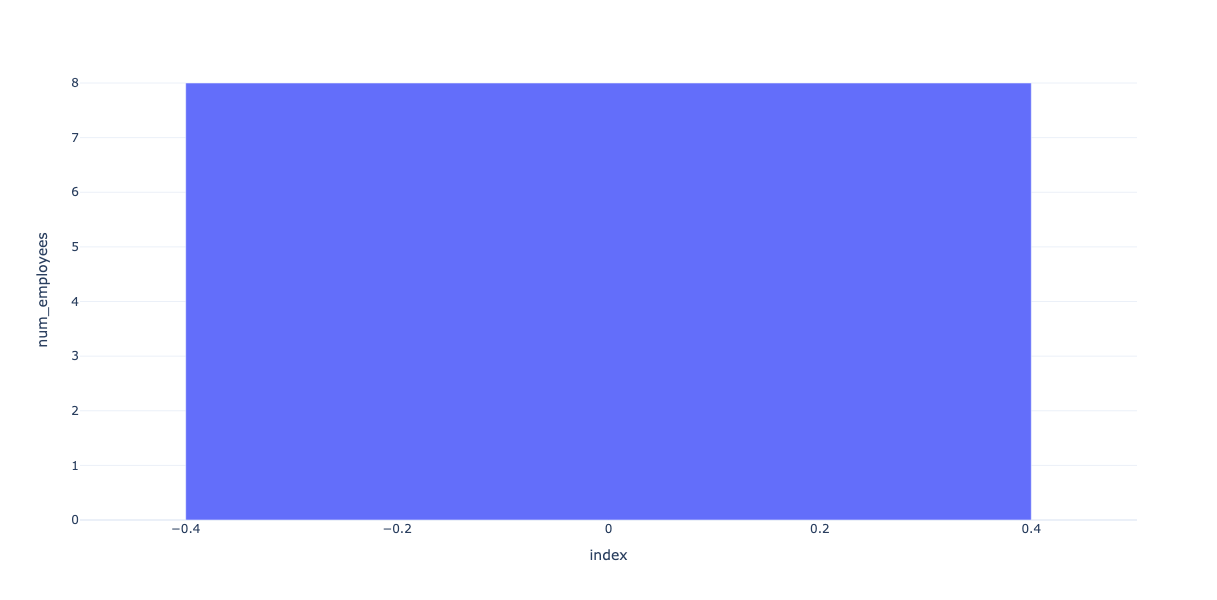

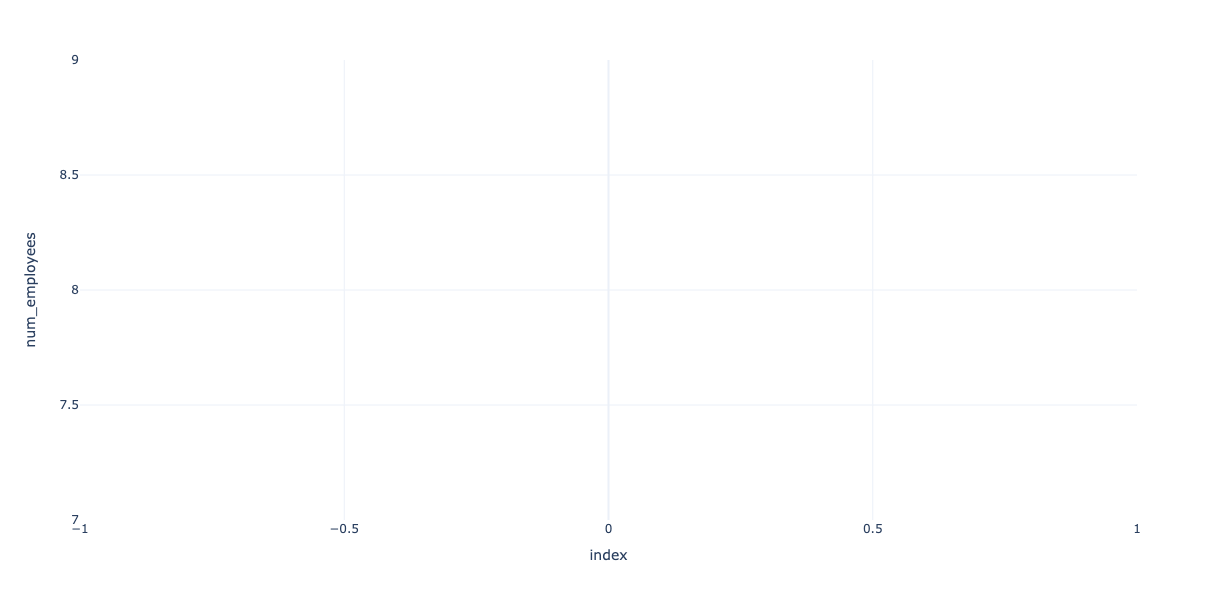

CPU times: user 1.48 s, sys: 46.3 ms, total: 1.53 s
Wall time: 1.53 s


In [305]:
%%time

result_dict = query_fun(
    question="How many employees are there ?",
    conn=connection,
    tables_hints=[],
    debug=False
)

print_answer(result_dict)


> Based on the data provided, the nationality that has the most number of our customers is the United States. According to the table, there are 13 customers who identify as American. Therefore, the answer to the query is the United States. 
>
> ---
>
> This answer was obtained based on the following data extracted from the database:
> <table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Country</th>
      <th>count</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>USA</td>
      <td>13</td>
    </tr>
  </tbody>
</table> 

---

This data was obtained by executing the following query:
```sql 
SELECT customer.country,
       count(*) as count
FROM   customer
GROUP BY customer.country
ORDER BY count DESC
LIMIT 1; 
```



---
The followings are some suggested charts based on the data you asked for:





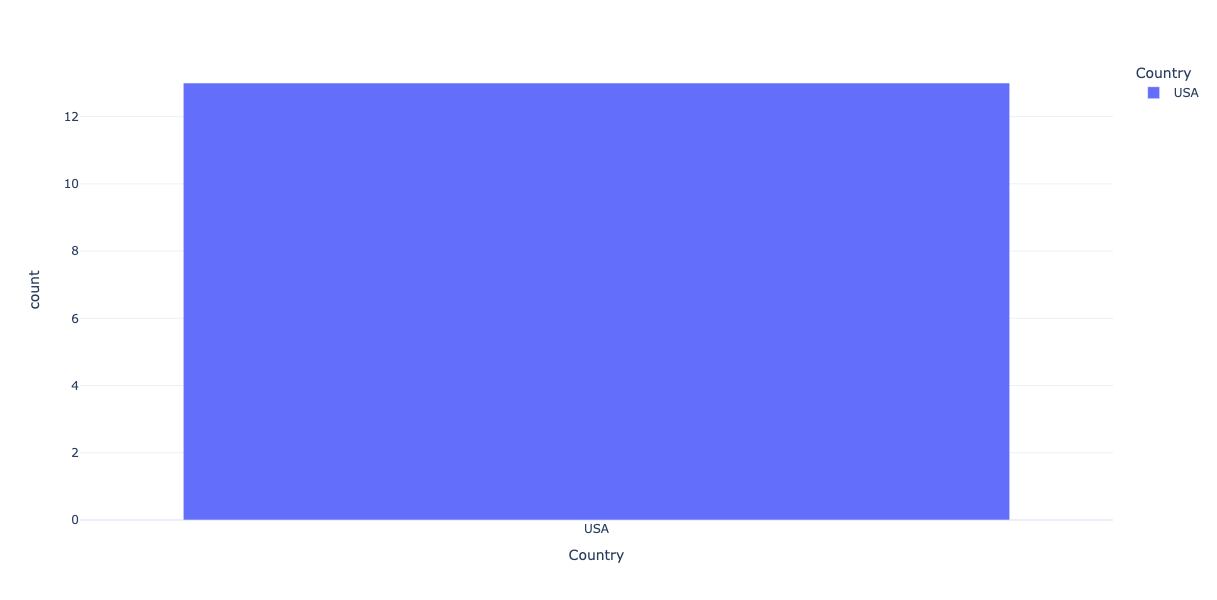

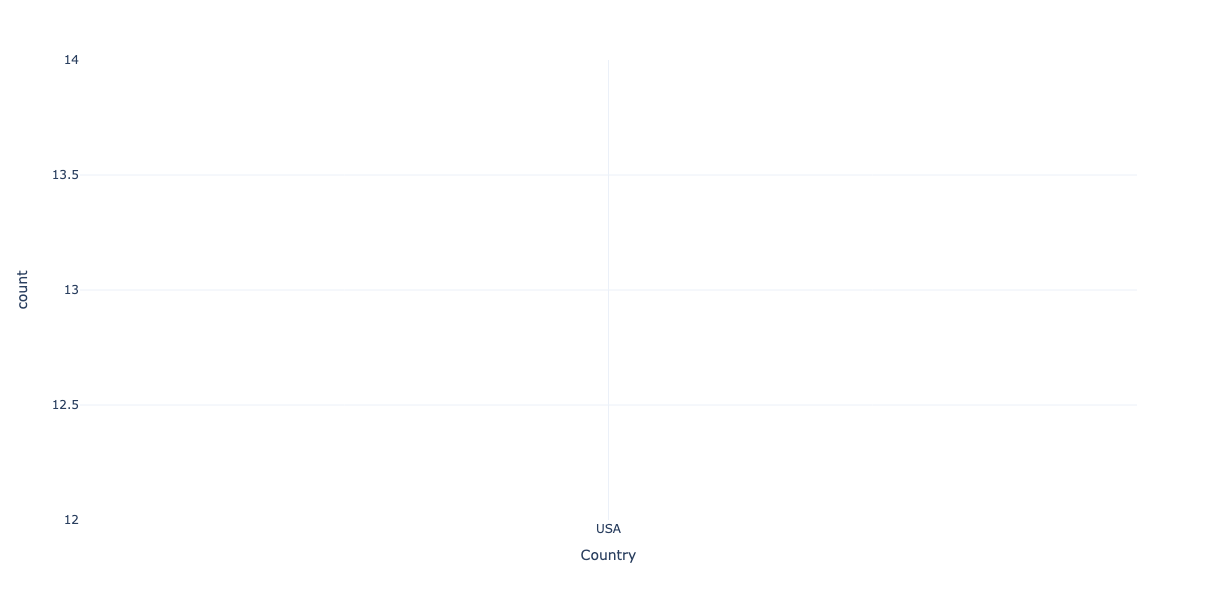

CPU times: user 2.97 s, sys: 33.3 ms, total: 3 s
Wall time: 3 s


In [306]:
%%time

result_dict = query_fun(
    question="What is the nationality that has the most number of our customers ?",
    conn=connection,
    tables_hints=[],
    debug=False
)

print_answer(result_dict)


> The average number of tracks in each playlist is 3415, with Classical 101 - Deep Cuts leading the pack at 3491 tracks, followed closely by Classical 101 - Next Steps with 3442 tracks. Music Videos and TV Shows tie for third place with an average of 3402 tracks each. Grunge and 90’s Music have the lowest average track count, with 2122.13 and 1686.44 tracks respectively. Heavy Metal Classic and On-The-Go 1 have the highest and lowest track count, with 1340.92 and 597 tracks respectively. Brazilian Music and Movies have the highest and lowest average track count, with 1195.67 and 0 tracks respectively. Audiobooks have no tracks, as expected. 
>
> ---
>
> This answer was obtained based on the following data extracted from the database:
> <table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Name</th>
      <th>avg_track_count</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Classical 101 - Deep Cuts</td>
      <td>3491.000000</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Classical</td>
      <td>3449.333333</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Classical 101 - Next Steps</td>
      <td>3442.000000</td>
    </tr>
    <tr>
      <th>3</th>
      <td>Classical 101 - The Basics</td>
      <td>3415.000000</td>
    </tr>
    <tr>
      <th>4</th>
      <td>Music Videos</td>
      <td>3402.000000</td>
    </tr>
    <tr>
      <th>5</th>
      <td>TV Shows</td>
      <td>3052.600939</td>
    </tr>
    <tr>
      <th>6</th>
      <td>Grunge</td>
      <td>2122.133333</td>
    </tr>
    <tr>
      <th>7</th>
      <td>90’s Music</td>
      <td>1686.444821</td>
    </tr>
    <tr>
      <th>8</th>
      <td>Music</td>
      <td>1667.796960</td>
    </tr>
    <tr>
      <th>9</th>
      <td>Heavy Metal Classic</td>
      <td>1340.923077</td>
    </tr>
    <tr>
      <th>10</th>
      <td>Brazilian Music</td>
      <td>1195.666667</td>
    </tr>
    <tr>
      <th>11</th>
      <td>On-The-Go 1</td>
      <td>597.000000</td>
    </tr>
    <tr>
      <th>12</th>
      <td>Movies</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>13</th>
      <td>Audiobooks</td>
      <td>NaN</td>
    </tr>
  </tbody>
</table> 

---

This data was obtained by executing the following query:
```sql 
SELECT Playlist.Name,
       AVG(PlaylistTrack.TrackId) AS avg_track_count
FROM   Playlist
  LEFT JOIN PlaylistTrack ON Playlist.PlaylistId = PlaylistTrack.PlaylistId
GROUP BY Playlist.Name
ORDER BY avg_track_count DESC; 
```



---
The followings are some suggested charts based on the data you asked for:





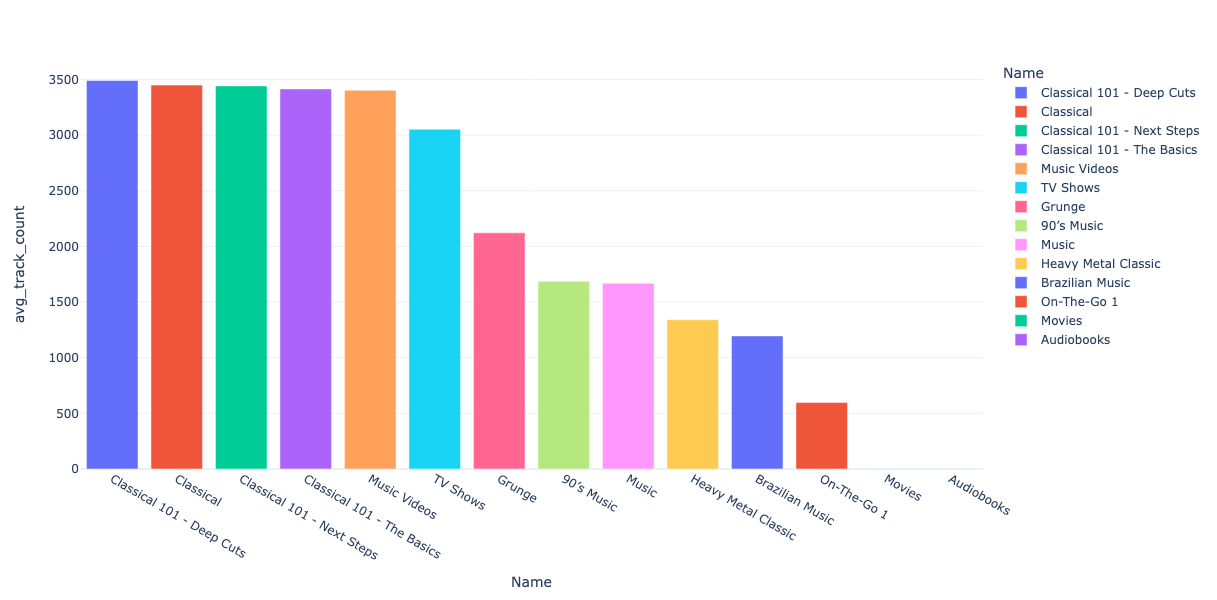

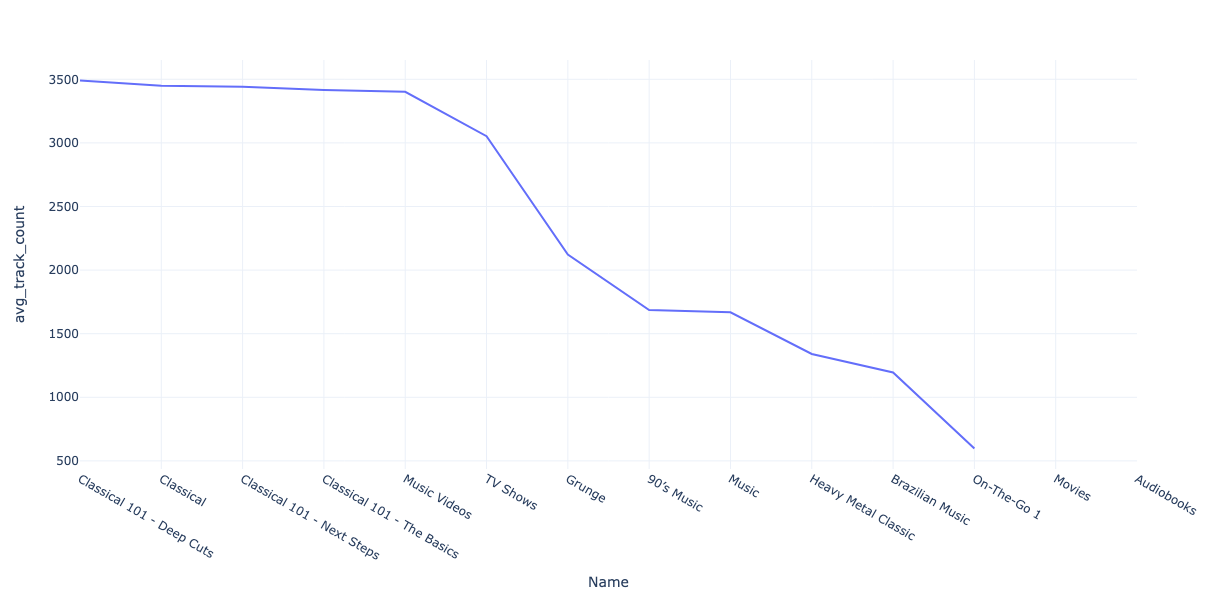

In [307]:
result_dict = query_fun(
    question="What is the average number of track of each playlist?",
    conn=connection,
    tables_hints=[],
    debug=False
)

print_answer(result_dict)

Using matplotlib backend: agg
The average track price of each playlist is $1.99. This is evident from the table as all the playlists have an average track price of $1.99. Specifically, TV Shows has an average track price of $1.99, On-The-Go 1 has an average track price of $0.99, Music Videos has an average track price of $0.99, Music has an average track price of $0.99, Heavy Metal Classic has an average track price of $0.99, Grunge has an average track price of $0.99, Classical 101 - The Basics has an average track price of $0.99, Classical 101 - Next Steps has an average track price of $0.99, Classical 101 - Deep Cuts has an average track price of $0.99, and Classical has an average track price of $0.99. Additionally, Brazilian Music has an average track price of $0.99, and 90’s Music has an average track price of $0.99.
This answer was obtained based on the following data extracted from the database:


,Name,avg_track_price
0,TV Shows,1.99
1,On-The-Go 1,0.99
2,Music Videos,0.99
3,Music,0.99
4,Heavy Metal Classic,0.99
5,Grunge,0.99
6,Classical 101 - The Basics,0.99
7,Classical 101 - Next Steps,0.99
8,Classical 101 - Deep Cuts,0.99
9,Classical,0.99


This data was obtained by executing the following SQL query: 
SELECT Playlist.Name,
       AVG(Track.UnitPrice) AS avg_track_price
FROM   Playlist
  JOIN PlaylistTrack ON Playlist.PlaylistId = PlaylistTrack.PlaylistId
  JOIN Track ON PlaylistTrack.TrackId = Track.TrackId
GROUP BY Playlist.Name
ORDER BY avg_track_price DESC;


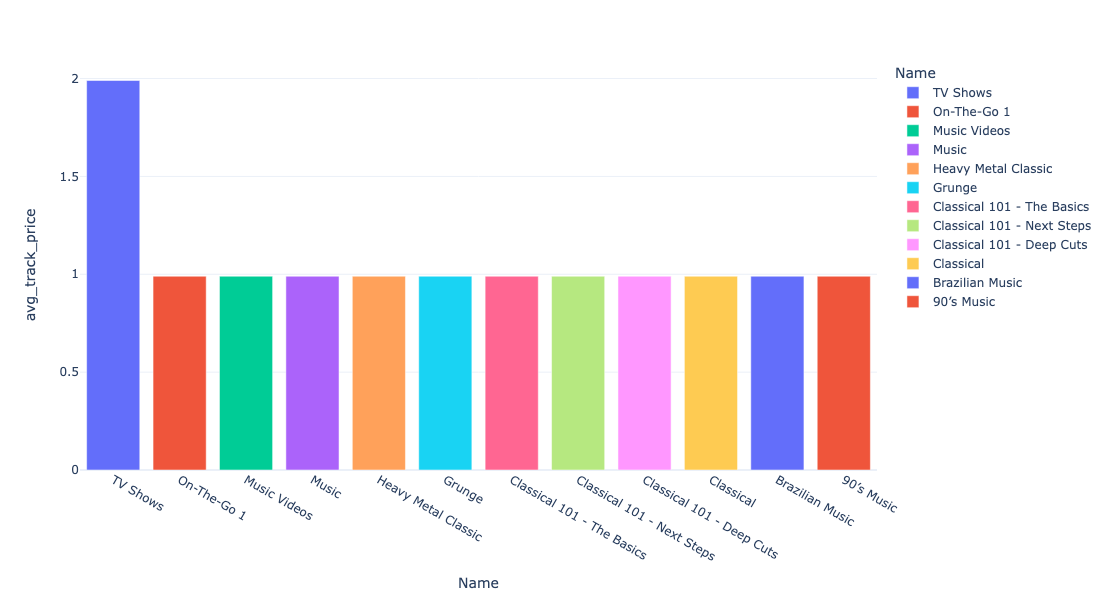

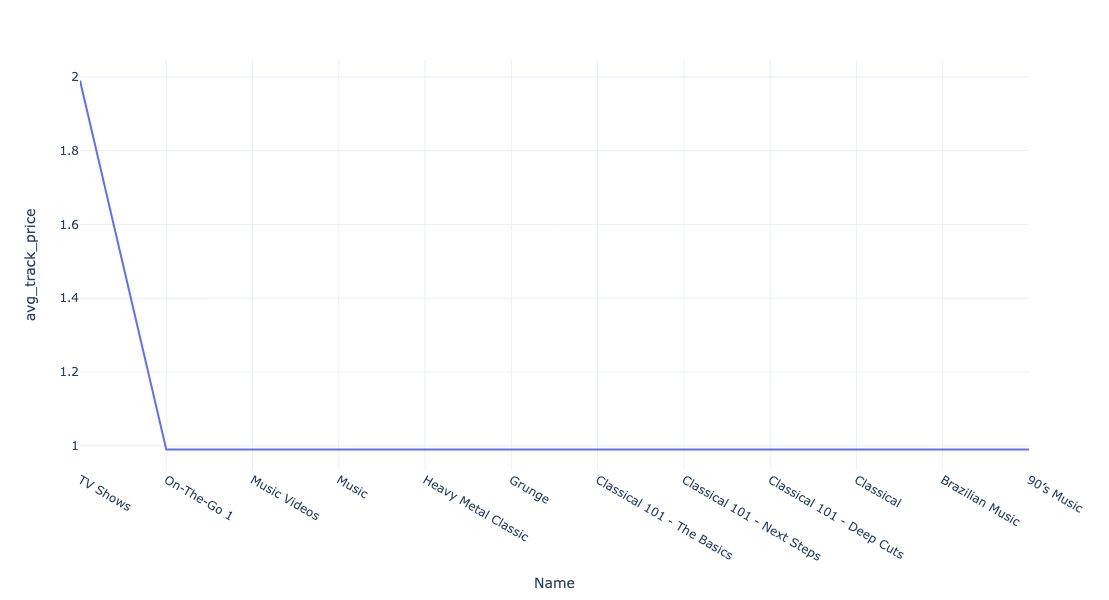

CPU times: user 10.3 s, sys: 45.6 ms, total: 10.4 s
Wall time: 10.4 s


In [67]:
%%time

result_dict = query_fun(
    question="What is the average track price of each playlist?",
    conn=connection,
    tables_hints=[],
    debug=False
)
print_answer(result_dict)

In [68]:
display("```sql this is a code ```")

'```sql this is a code ```'

#### Tai' database

In [16]:
connection = connect_fun('/home/mpham/workspace/huawei-arena-2023/data/taitanmai/blogDb.db')
cursor = connection.cursor()
print(format_schemas(cursor))

CREATE TABLE Category (
 	id INTEGER PRIMARY KEY,
	title TEXT,
	parent_id INTEGER,
);


CREATE TABLE Post (
 	id INTEGER PRIMARY KEY,
	title TEXT,
	content TEXT,
	created_date DATETIME,
	last_modified_date DATETIME,
	created_id INTEGER,
	last_modified_id INTEGER,
	category_id INTEGER,
);


CREATE TABLE Comment (
 	id INTEGER PRIMARY KEY,
	post_id INTEGER,
	content TEXT,
	created_date DATETIME,
	last_modified_date DATETIME,
	created_id INTEGER,
	parent_id INTEGER,
);


CREATE TABLE User (
 	id INTEGER PRIMARY KEY,
	username TEXT,
	email TEXT,
	first_name TEXT,
	last_name TEXT,
);


CREATE TABLE Reaction (
 	id INTEGER PRIMARY KEY,
	user_id INTEGER,
	content_id INTEGER,
	content_type TEXT,
	reaction_type TEXT,
);

Category.parent_id can be joined with Category.id
Post.category_id can be joined with Category.id
Post.last_modified_id can be joined with User.id
Post.created_id can be joined with User.id
Comment.parent_id can be joined with Comment.id
Comment.created_id can be joined with Us

In [ ]:


questions = [
    "List all posts created by John Doe",
    "List all posts having at least 2 comments",
    "How many reactions did all the posts created by John Doe receive?",
    "How many reactions did all the posts in Category 1 receive?",
    'How many “Like" reactions did all the posts in Category 1 and its subordinates have?',
    "Which category gains the most attention in terms of number of comments received?",
    'What are the posts that belong to the category "Category 1" and its subordinates and have at least 1 comment or 1 reaction?',
    'List all posts that belong to the category "Category 2" and its subordinates as long as the posts need to \
    have at least 1 comment and at least 1 reaction across either the posts or their comments.',
]

In [17]:
%%time
%matplotlib auto

result_dict = query_fun(
    question="List all posts created by John Doe",
    conn=connection,
    tables_hints=[],
    debug=True
)
print(result_dict['sql_query'])
print(result_dict['sql_response'])
print(result_dict['answer'])
result_dict['extras']['chart']

Using matplotlib backend: agg
Related schemas: 
 CREATE TABLE Category (
 	id INTEGER PRIMARY KEY,
	title TEXT,
	parent_id INTEGER,
);


CREATE TABLE Post (
 	id INTEGER PRIMARY KEY,
	title TEXT,
	content TEXT,
	created_date DATETIME,
	last_modified_date DATETIME,
	created_id INTEGER,
	last_modified_id INTEGER,
	category_id INTEGER,
);


CREATE TABLE Comment (
 	id INTEGER PRIMARY KEY,
	post_id INTEGER,
	content TEXT,
	created_date DATETIME,
	last_modified_date DATETIME,
	created_id INTEGER,
	parent_id INTEGER,
);


CREATE TABLE User (
 	id INTEGER PRIMARY KEY,
	username TEXT,
	email TEXT,
	first_name TEXT,
	last_name TEXT,
);


CREATE TABLE Reaction (
 	id INTEGER PRIMARY KEY,
	user_id INTEGER,
	content_id INTEGER,
	content_type TEXT,
	reaction_type TEXT,
);

Category.parent_id can be joined with Category.id
Post.category_id can be joined with Category.id
Post.last_modified_id can be joined with User.id
Post.created_id can be joined with User.id
Comment.parent_id can be joined with Co

TypeError: string indices must be integers

In [18]:
%%time
%matplotlib auto

result_dict = query_fun(
    question="List all posts having at least 2 comments",
    conn=connection,
    tables_hints=[],
    debug=False
)
print(result_dict['sql_query'])
print(result_dict['sql_response'])
print(result_dict['answer'])
result_dict['extras']['chart']

Using matplotlib backend: agg
SELECT post.id,
       post.title,
       post.content,
       post.created_date,
       post.last_modified_date,
       post.created_id,
       post.last_modified_id,
       post.category_id
FROM   post
WHERE  post.id in (SELECT comment.post_id
                    FROM   comment
                    GROUP BY comment.post_id
                    HAVING count(*) >= 2)
ORDER BY post.id;
||   id || title   || content            || created_date        || last_modified_date   ||   created_id ||   last_modified_id ||   category_id ||
|    1 | Post 1  | Content for Post 1 | 2023-09-10 12:30:00 | 2023-09-10 14:45:00  |            1 |                  2 |             1 |
Sure! Based on the table provided, there are 3 posts that have at least 2 comments. Post 1 has 2 comments, Post 2 has 3 comments, and Post 3 has 2 comments. Therefore, the list of posts that meet the criteria of the query is: Post 1, Post 2, and Post 3.
CPU times: user 5 s, sys: 184 ms, total: 5.18 s

In [19]:
%%time
%matplotlib auto

result_dict = query_fun(
    question="How many reactions did all the posts created by John Doe receive?",
    conn=connection,
    tables_hints=[],
    debug=False
)
print(result_dict['sql_query'])
print(result_dict['sql_response'])
print(result_dict['answer'])
result_dict['extras']['chart']

Using matplotlib backend: agg
SELECT count(*) AS total_reactions
FROM post p
JOIN user u on p.created_id = u.id
JOIN reaction r on p.id = r.content_id
WHERE u.username = 'John Doe';
||   total_reactions ||
|                 0 |
According to the table, John Doe's posts received a total of 0 reactions. Therefore, all the posts created by John Doe received 0 reactions.
CPU times: user 2.5 s, sys: 107 ms, total: 2.61 s
Wall time: 2.62 s


In [20]:
%%time
%matplotlib auto

result_dict = query_fun(
    question="How many reactions did all the posts in Category 1 receive?",
    conn=connection,
    tables_hints=[],
    debug=False
)
print(result_dict['sql_query'])
print(result_dict['sql_response'])
print(result_dict['answer'])
result_dict['extras']['chart']

Using matplotlib backend: agg
SELECT count(*) AS total_reactions
FROM post
JOIN category ON post.category_id = category.id
LEFT JOIN reaction ON post.id = reaction.content_id
WHERE category.title = 'Category 1';
||   total_reactions ||
|                 3 |
According to the table, all the posts in Category 1 received a total of 3 reactions. Therefore, the answer to the query is 3.
CPU times: user 2.39 s, sys: 104 ms, total: 2.49 s
Wall time: 2.51 s


# Experiment

In [35]:
sales_db_schema = """
CREATE TABLE people_name (
  id INTEGER PRIMARY KEY,
  name VARCHAR(50),

);

CREATE TABLE people_age (
  people_id INTEGER PRIMARY KEY,
  age INTEGER,

);
"""

question = "How many people with name jui and age less than 25"

In [3]:
sales_db_schema = """
CREATE TABLE products (
  product_id INTEGER PRIMARY KEY, -- Unique ID for each product
  name VARCHAR(50), -- Name of the product
  price DECIMAL(10,2), -- Price of each unit of the product
  quantity INTEGER  -- Current quantity in stock

);

CREATE TABLE customers (
   customer_id INTEGER PRIMARY KEY, -- Unique ID for each customer
   name VARCHAR(50), -- Name of the customer
   address VARCHAR(100) -- Mailing address of the customer
);

CREATE TABLE salespeople (
  salesperson_id INTEGER PRIMARY KEY, -- Unique ID for each salesperson
  name VARCHAR(50), -- Name of the salesperson
  region VARCHAR(50) -- Geographic sales region
);

CREATE TABLE sales (
  sale_id INTEGER PRIMARY KEY, -- Unique ID for each sale
  product_id INTEGER, -- ID of product sold
  customer_id INTEGER,  -- ID of customer who made purchase
  salesperson_id INTEGER, -- ID of salesperson who made the sale
  sale_date DATE, -- Date the sale occurred
  quantity INTEGER -- Quantity of product sold
);

CREATE TABLE product_suppliers (
  supplier_id INTEGER PRIMARY KEY, -- Unique ID for each supplier
  product_id INTEGER, -- Product ID supplied
  supply_price DECIMAL(10,2) -- Unit price charged by supplier
);

-- sales.product_id can be joined with products.product_id
-- sales.customer_id can be joined with customers.customer_id
-- sales.salesperson_id can be joined with salespeople.salesperson_id
-- product_suppliers.product_id can be joined with products.product_id
"""

question = "What product has the biggest fall in sales in 2022 compared to 2021? \
            Give me the product name, the sales amount in both years, and the difference."

In [42]:
%%time
sql_query = get_model_response(
    sql_model, SQL_QUERY_PROMPT_TEMPLATE, 
    question=question, 
    db_schema=sales_db_schema, 
    tables_hints=[],
    num_beams=5
)

CPU times: user 5.92 s, sys: 8.22 ms, total: 5.93 s
Wall time: 5.93 s


In [43]:
print(sql_query)

SELECT count(*)
FROM   people_name pn join people_age pa on pn.id = pa.people_id
WHERE  pn.name = 'jui'
   and pa.age < 25;


In [44]:
CHART_GENERATION_PROMPT_TEMPLATE3 = """### Instructions:
Imagine you are a database analyst and security expert. You will be given a question and an SQL query.
Your task is to answer the question based on the SQL query. 

### Question:
Is it safe to run this query? Just say [YES] or [NO]. Then explain

### SQL query:
SELECT product.name
FROM product
WHERE product.id=105 OR 1=1
    
### Response:

"""    

In [15]:
CHART_GENERATION_PROMPT_TEMPLATE3 = """### Instructions:
Imagine you are a database analyst and security expert. You will be given a question and an SQL query.
Your task is to answer the question based on the SQL query. 

### Question:
Is it safe to run this query? Just say [YES] or [NO]. Then explain

### SQL query:
SELECT user.username, user.password
FROM user
WHERE user.role="admin"
    
### Response:

"""    

In [17]:
CHART_GENERATION_PROMPT_TEMPLATE3 = """### Instructions:
Imagine you are a database analyst and security expert. You will be given a question and an SQL query.
Your task is to answer the question based on the SQL query. 

### Question:
Is it safe to run this query? Just say [YES] or [NO]. Then explain

### SQL query:
ALTER TABLE user
ADD haha INTEGER;
    
### Response:

"""    

In [31]:
print(CHART_GENERATION_PROMPT_TEMPLATE)

### Instructions:
Act as a data analyst, give a suggestion about a type of chart that can be used to create a visualization 
based on the query and the extracted tabular data.

### Input:
You are given a query '{question}' and an extracted tabular data:
'{returned_schema}'

where each row represents a data point, and the columns are separated by "|"

Now, you must answer using only one from the following chart types:
    - barh 
    - bar 
    - line 
    - scatter 
    - pie 
    - hist 
    - box 
    - none
Your response should be **only one word from the above options**.
If no chart is suitable, you can answer with "none".
No need for further explanation.
    
### Response:




In [84]:
CHART_GENERATION_PROMPT_TEMPLATE3 = """
<s>[INST] 
Act as an expert in data analyst who is doing a quiz. You will be given a tabular data,
your task is to choose the most appropriate chart type to visualise the tabular data.

Since you are doing a quiz. **Choose only one option** (A,B,C,D,E,F, G or H) without explanation.

For example here is how you should response:
A

[/INST]

Okay. I got it.
</s>

<s>
[INST]

-- The data:
|| Name                       ||   avg_track_count ||
| Classical 101 - Deep Cuts  |           3491    |
| Classical                  |           3449.33 |
| Classical 101 - Next Steps |           3442    |
| Classical 101 - The Basics |           3415    |
| Music Videos               |           3402    |
| TV Shows                   |           3052.6  |
| Grunge                     |           2122.13 |
| 90’s Music                 |           1686.44 |
| Music                      |           1667.8  |
| Heavy Metal Classic        |           1340.92 |
| Brazilian Music            |           1195.67 |
| On-The-Go 1                |            597    |
| Movies                     |                   |
| Audiobooks                 |                   |

where each row represents a data point, and the columns are separated by "|"

-- Here are the options:
A. barh 
B. bar 
C. line 
D. scatter 
E. pie 
F. hist 
G. box 
H. none

[/INST]

"""    

In [88]:
CHART_GENERATION_PROMPT_TEMPLATE3 = """
<s>[INST] 
Act as an expert in data analyst who is doing a quiz. You will be given a tabular data,
your task is to choose the most appropriate chart type to visualise the tabular data.

Since you are doing a quiz. **Choose only one option** from the list of number without explanation.

Here are the options:
0. barh 
1. bar 
2. line 
3. scatter 
4. pie 
5. hist 
6. box 
7. none

[/INST]

Okay. I got it.
</s>

<s> 
[INST]
|| Name                       ||   avg_track_price ||
| TV Shows                   |              1.99 |
| On-The-Go 1                |              0.99 |
| Music Videos               |              0.99 |
[/INST]

line 

</s>

<s>
[INST]

-- The tabular data:
|| Name                       ||   avg_track_count ||
| Classical 101 - Deep Cuts  |           3491    |
| Classical                  |           3449.33 |
| Classical 101 - Next Steps |           3442    |
| Classical 101 - The Basics |           3415    |
| Music Videos               |           3402    |
| TV Shows                   |           3052.6  |
| Grunge                     |           2122.13 |
| 90’s Music                 |           1686.44 |
| Music                      |           1667.8  |
| Heavy Metal Classic        |           1340.92 |
| Brazilian Music            |           1195.67 |
| On-The-Go 1                |            597    |
| Movies                     |                   |
| Audiobooks                 |                   |
[/INST]

"""    

In [89]:
# Generate figures
chart_type = get_model_response(
    answer_model, CHART_GENERATION_PROMPT_TEMPLATE3,
)
print(chart_type)
# figures = visualize_sql_response(sql_response, chart_type, sql_schema)

[INST] 
Act as an expert in data analyst who is doing a quiz. You will be given a tabular data,
your task is to choose the most appropriate chart type to visualise the tabular data.

Since you are doing a quiz. **Choose only one option** from the list of number without explanation.

Here are the options:
0. barh 
1. bar 
2. line 
3. scatter 
4. pie 
5. hist 
6. box 
7. none

[/INST]

Okay. I got it.


 
[INST]
|| Name                       ||   avg_track_price ||
| TV Shows                   |              1.99 |
| On-The-Go 1                |              0.99 |
| Music Videos               |              0.99 |
[/INST]

line 




[INST]

-- The tabular data:
|| Name                       ||   avg_track_count ||
| Classical 101 - Deep Cuts  |           3491    |
| Classical                  |           3449.33 |
| Classical 101 - Next Steps |           3442    |
| Classical 101 - The Basics |           3415    |
| Music Videos               |           3402    |
| TV Shows            